# This is an LSTM on the last word of a stream

In [1]:
from __future__ import print_function
import os
import pickle
import numpy as np
import pandas as pd
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.optimizers import RMSprop
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5004)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
os.chdir('/Users/franciscojavierarceo/GitHub/DeepNLPQLearning/DO_NOT_UPLOAD_THIS_DATA/corpus-data/')

In [3]:
w2indx = pickle.load(open('./0-output/LSTMDQN_Dic_token2id.pkl', 'rb'))
indx2w = pickle.load(open('./0-output/LSTMDQN_Dic_id2token.pkl', 'rb'))

In [4]:
len(w2indx), len(indx2w)

(239587, 239587)

In [5]:
adf = pd.read_csv('./0-output/2012_aurora_shooting_numtext.csv')

In [31]:
rans = np.random.random((adf.shape[0],1)) >0.9
rans2 = np.random.random((adf.shape[0],1)) >0.9
rans3 = (rans==False)*rans2
X_train, X_test = adf.values[rans], adf.values[rans3]

In [32]:
X_train = np.asarray([ [int(j) for j in i.split(" ")] for i in X_train])
X_test = np.asarray([ [int(j) for j in i.split(" ")] for i in X_test])

In [34]:
X_train.shape, X_test.shape

((20214,), (18111,))

In [35]:
emb_dim = 10
batch_size = 32

# Taking the last element of X_train[i] as our outcome
Y_train = np.asarray([i[-1] for i in X_train]) 
Y_test = np.asarray([ i[-1] for i in X_test])

# Removing the last element of X_train[i]
X_train = np.asarray([i[:-1] for i in X_train]) 
X_test = np.asarray([i[:-1] for i in X_test] )

In [36]:
print([x for x in X_train[0]])

[211, 23, 209, 22, 69, 34, 0, 69, 210, 124, 104, 119, 213, 212, 106, 81, 66, 45, 48]


In [37]:
print ([indx2w[x] for x in X_train[0]])

[u'With', u'the', u'introduction', u'of', u'our', u'son', u'and', u'our', u'interaction', u'with', u'children', u'who', u'have', u'special', u'needs', u'it', u's', u'become', u'more']


In [38]:
len(np.unique(X_train)), len(np.unique(Y_train))

(19457, 6660)

In [39]:
print(indx2w[Y_train[0]])

significant


In [40]:
maxlen=40

In [41]:
# RNN for the regular embedings
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
# The pad sequences stuff seems suspicious
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

20214 train sequences
18111 test sequences
Pad sequences (samples x time)
X_train shape: (20214, 40)
X_test shape: (18111, 40)


In [42]:
print('Build model...')
model = Sequential()
model.add(Embedding(129541, emb_dim)) # , dropout=0.2))
model.add(LSTM(150))
model.add(Dense(len(indx2w)))
model.add(Activation('softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

optimizer = RMSprop(lr=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          validation_data=(X_test, Y_test), verbose=0)

# Running the predictions
out = model.evaluate(X_test, Y_test, batch_size=batch_size)
ypred_tst = model.predict(X_test)

Build model...
Train...
18111/18111 [==============================] - 52s    


In [43]:
print('Cross Entropy Loss of %0.3f' % out)

yprdtst = np.argmax(ypred_tst, axis=1)
x = confusion_matrix(yprdtst, Y_test).astype('float') 
# Normalizing it
x_n = x/ x.sum(axis=0)

print ('Classification Accuracy is %0.3f' % (np.diag(x).sum()/ x.sum()))

Cross Entropy Loss of 8.822
Classification Accuracy is 0.074


In [53]:
x_n.shape

(6188, 6188)

In [59]:
x_n[:,0].argmax()

36

In [62]:
x_n[:,0].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2222222222222222,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

(array([  3.82830560e+07,   5.34000000e+02,   5.87000000e+02,
          5.66000000e+02,   1.72000000e+02,   1.17200000e+03,
          2.99000000e+02,   1.34000000e+02,   1.42000000e+02,
          4.68200000e+03]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

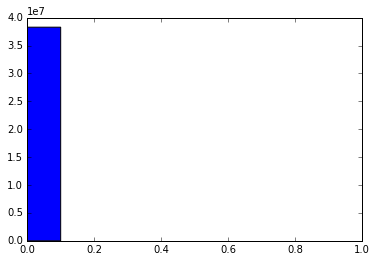

In [54]:
plt.hist(x_n.reshape((6188**2, 1)))

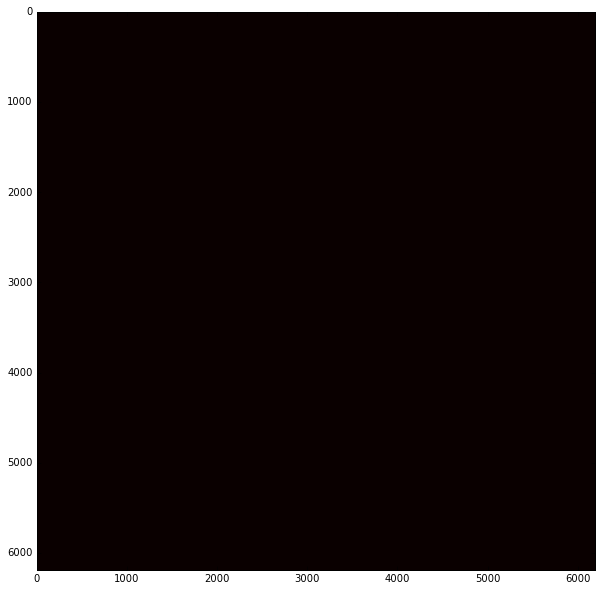

In [63]:
# Look at the confusion matrix image
plt.figure(figsize=(15,10))
plt.imshow(x_n, cmap='hot')
plt.show()

In [64]:
x = np.linspace(0, 100)

In [65]:
x

array([   0.        ,    2.04081633,    4.08163265,    6.12244898,
          8.16326531,   10.20408163,   12.24489796,   14.28571429,
         16.32653061,   18.36734694,   20.40816327,   22.44897959,
         24.48979592,   26.53061224,   28.57142857,   30.6122449 ,
         32.65306122,   34.69387755,   36.73469388,   38.7755102 ,
         40.81632653,   42.85714286,   44.89795918,   46.93877551,
         48.97959184,   51.02040816,   53.06122449,   55.10204082,
         57.14285714,   59.18367347,   61.2244898 ,   63.26530612,
         65.30612245,   67.34693878,   69.3877551 ,   71.42857143,
         73.46938776,   75.51020408,   77.55102041,   79.59183673,
         81.63265306,   83.67346939,   85.71428571,   87.75510204,
         89.79591837,   91.83673469,   93.87755102,   95.91836735,
         97.95918367,  100.        ])

In [66]:
alpha = 3600. * 6.

In [ ]:
1. - 2./np.pi * np.arctan( (u_t - n_t)/alpha )